Customer segmentation is the practice of dividing customers into groups that reflect the similarities between the customers in each cluster. I will divide customers into segments to optimize each customer's importance to the business. This helps to modify products according to clearly defined customer needs and behaviors. It also helps the business to cater to the needs of different types of customers.

Import the libraries that will be needed to solve the problem:

In [ ]:
import matplotlib
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

Load the dataset for analysis:

In [ ]:
#Загружаем данные
data = pd.read_csv("./mark_camp.csv", sep="\t")
print("Number of data in the set:", len(data))
data.head()

Number of data in the set: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Let's look at data cleansing. Let's take a look at the information contained in the data to see what we need to clean it up

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

From the function used above, it can be noted that:

There are missing values in the revenue

Dt_Customer, which indicates the date when the customer appeared in the database,is not analyzed as date and time

There are some categorical functions in our data frame; just like there are some dtype: object) functions. So later we need to code them into numeric forms.

First of all, for the missing values, I will just delete the rows that have missing income values.

In [ ]:
data = data.dropna()
print("The total number of data points after removing rows with missing values is:", len(data))

The total number of data points after removing rows with missing values is: 2216


Next, I'll create a function from "Dt_custmr" that specifies the number of days a client has been registered in the firm's database. However, to simplify the task, I take this value relative to the last client in the record.

Thus, to get the values, I have to check the newest and oldest recorded dates.

In [ ]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)
#Dates of the newest and oldest recorded customer
print("Date of registration of the last client in the records:",max(dates))
print("Oldest date of client registration in records:",min(dates))

Date of registration of the last client in the records: 2014-12-06
Oldest date of client registration in records: 2012-01-08


<ipython-input-68-0d8e6cc2fcdb>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])


Create a function ("Cust_f") of the number of days customers started shopping at the store, relative to the last recorded date.

In [ ]:
#Create column "Cust_F"
days = []
d1 = max(dates) #take on a new client
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Cust_F"] = days
data["Cust_F"] = pd.to_numeric(data["Cust_F"], errors="coerce")

We will now look at unique values in categorical functions to get a clear view of the data.

In [ ]:
print("Total number of categories in the column Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the section of Education:\n", data["Education"].value_counts())

Total number of categories in the column Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Total categories in the section of Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


Next, let's perform the following steps to develop some new features:

Let's extract the "Age" of the customer by "Birth_Year", indicating the birth year of the respective person.

Let's create another column "Spent" indicating the total amount spent by the customer, in different categories, over a period of two years.

Create a "Living_with" column from "Mar_sts" to extract the marital status of couples.

Let's create a "Children" column to indicate the total number of children in the family.

To have an understanding of the number of family members, create a "Family_size" column.

Create the "Is_parent" column to indicate the status of the parent.

The penultimate item, let's create three categories, under "Education", to simplify the calculation of its value.

Let's delete the unnecessary columns.

In [ ]:
revenue=data['Z_Revenue']

In [ ]:
#Designing features
#Customer age today
data["Age"] = 2021-data["Year_Birth"]

#Total expenditure on miscellaneous items
data["Spent"] =  data[["MntWines", "MntFruits", "MntMeatProducts",
                       "MntFishProducts", "MntSweetProducts", "MntGoldProds"]].sum(axis=1)

#Determination of living situation by marital status "Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone",
                                                    "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Characteristic indicating the total number of children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Characteristics for all household members
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#A feature relating to the status of parents
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Division of education levels into three groups
data["Edctn"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate",
                                             "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat",
                          "MntFishProducts":"Fish",
                          "MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Removal of some redundant functions
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue",
           "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

Now that we have new columns, let's look at the data again:

In [ ]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Cust_F,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


In this task, there are many factors based on which the final classification will be made. These factors are mostly attributes or features, but the greater the number of columns, the more difficult they are to handle.  Many of these columns are interrelated and hence redundant.  Therefore, we will perform dimensionality reduction on selected objects before passing them through the classifier. Dimensionality reduction is the process of reducing the number of random variables under consideration by obtaining a set of principal variables.

Principal component analysis (PCA) - is a method of reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing loss of information.

For this project, we will reduce the dimensionality to 3.

In [ ]:
data

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Complain,Response,Cust_F,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Edctn
0,Graduation,58138.0,0,0,58,635,88,546,172,88,...,0,1,83894400000000000,64,1617,Alone,0,1,0,Graduate
1,Graduation,46344.0,1,1,38,11,1,6,2,1,...,0,0,10800000000000000,67,27,Alone,2,3,1,Graduate
2,Graduation,71613.0,0,0,26,426,49,127,111,21,...,0,0,40780800000000000,56,776,Partner,0,2,0,Graduate
3,Graduation,26646.0,1,0,26,11,4,20,10,3,...,0,0,5616000000000000,37,53,Partner,1,3,1,Graduate
4,PhD,58293.0,1,0,94,173,43,118,46,27,...,0,0,27734400000000000,40,422,Partner,1,3,1,Postgraduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduation,61223.0,0,1,46,709,43,182,42,118,...,0,0,46742400000000000,54,1341,Partner,1,3,1,Graduate
2236,PhD,64014.0,2,1,56,406,0,30,0,0,...,0,0,5270400000000000,75,444,Partner,3,5,1,Postgraduate
2237,Graduation,56981.0,0,0,91,908,48,217,32,12,...,0,0,27216000000000000,40,1241,Alone,0,1,0,Graduate
2238,Master,69245.0,0,1,8,428,30,214,80,30,...,0,0,27302400000000000,65,843,Partner,1,3,1,Postgraduate


In [ ]:
data.Education.unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [ ]:
# Define a dictionary mapping each category to its numerical value
education_mapping = {'Basic': 1, '2n Cycle': 2, 'Graduation': 3, 'Master': 4, 'PhD': 5}

# Replace values in the 'Education' column using the mapping
data['Education'] = data['Education'].map(education_mapping)


In [ ]:
data.Living_With.unique()

array(['Alone', 'Partner'], dtype=object)

In [ ]:
# Define a dictionary mapping each category to its numerical value
living_with_mapping = {'Alone': 1, 'Partner': 0}

# Replace values in the 'Living_With' column using the mapping
data['Living_With'] = data['Living_With'].map(living_with_mapping)


In [ ]:
data.Edctn.unique()

array(['Graduate', 'Postgraduate', 'Undergraduate'], dtype=object)

In [ ]:
data.drop('Edctn',axis=1,inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Apply MinMaxScaler to all numerical columns
scaler = MinMaxScaler()
scaled_ds = scaler.fit_transform(data)


In [ ]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["column1","column2", "column3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
column1,2216.0,8.336693e-17,0.691711,-1.156165,-0.541964,-0.242392,0.504448,1.958490
column2,2216.0,5.611236e-18,0.493792,-0.768587,-0.380946,-0.251852,0.570256,0.933458
column3,2216.0,1.923852e-17,0.406462,-0.967817,-0.308428,-0.004317,0.248842,1.654265


In [ ]:
# Calculate the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Print the explained variance ratio for each component
for i, evr in enumerate(explained_variance_ratio):
    print(f"Explained Variance Ratio for Component {i+1}: {evr:.2%}")

# Print the cumulative explained variance ratio
print(f"Cumulative Explained Variance Ratio: {cumulative_explained_variance_ratio[-1]:.2%}")

Explained Variance Ratio for Component 1: 28.23%
Explained Variance Ratio for Component 2: 14.39%
Explained Variance Ratio for Component 3: 9.75%
Cumulative Explained Variance Ratio: 52.37%


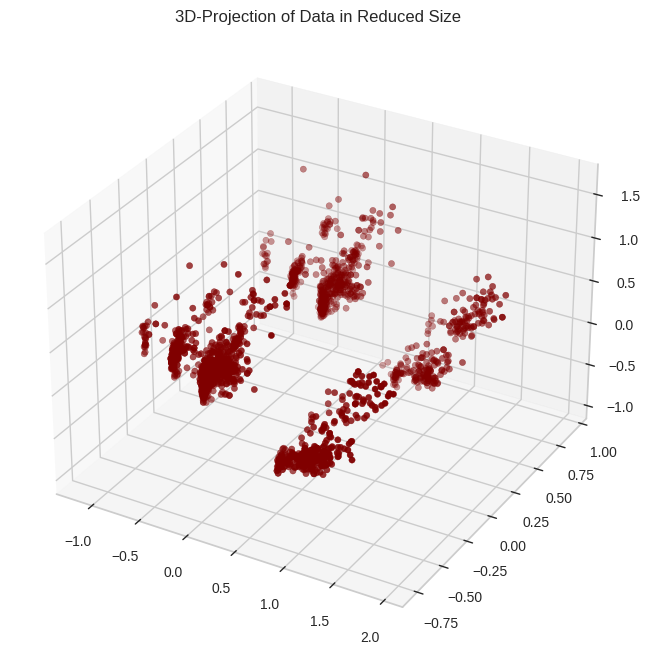

In [ ]:
x =PCA_ds["column1"]
y =PCA_ds["column2"]
z =PCA_ds["column3"]

figure = plt.figure(figsize=(10,8))
at = figure.add_subplot(111, projection="3d")
at.scatter(x,y,z, c="maroon", marker="o" )
at.set_title("3D-Projection of Data in Reduced Size")
plt.show()

Now that we have reduced the attributes to three dimensions, we will perform clustering, namely agglomerative clustering. Agglomerative clustering is a hierarchical clustering method, it involves combining examples until the desired number of clusters is reached.

Steps involved in clustering:

Elbow method to determine the number of clusters to be formed;

Clustering using agglomerative clustering;

Studying the clusters formed using dot plot.

Elbow method to find the number of clusters to be generated:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

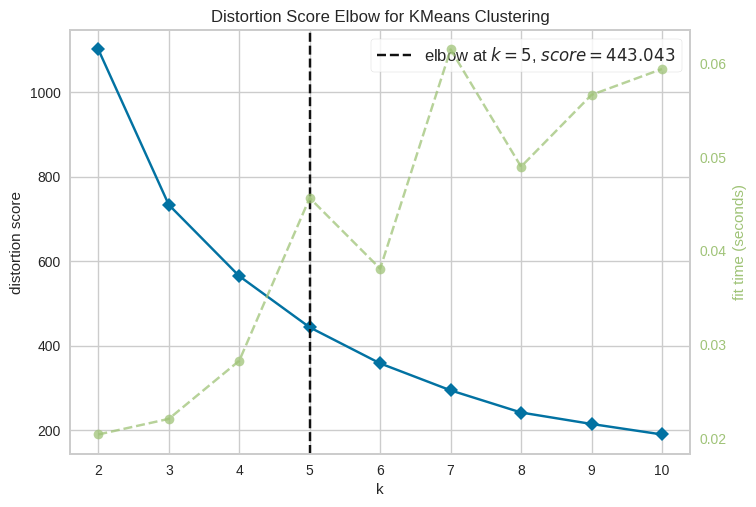

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#elbow method to find the number of clusters to create.
print('Elbow method to find the number of clusters to be generated:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

From the above graph, we can conclude that 5 would be the optimal number of clusters for this data. Next, we will fit the agglomerative clustering model to get the final number of clusters.

For this project, we will reduce the dimensions to 3.

In [ ]:
#Initiation of agglomerative clustering model
AC = AgglomerativeClustering(n_clusters=5)
#fitting the model and predicting clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Add the clusters function to the original data frame
data["Clusters"]= yhat_AC

To study the clusters formed, let's take a look at the three-dimensional distribution of the clusters

<ipython-input-84-be5b8f76882c>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


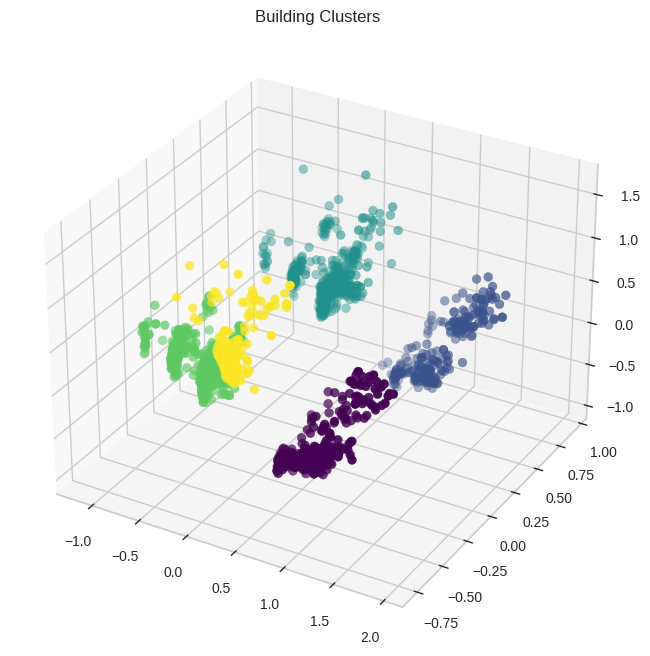

In [ ]:
#Build graphs of clusters
cmap = plt.cm.get_cmap('viridis')
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("Building Clusters")
plt.show()

if we choose 3 cluster

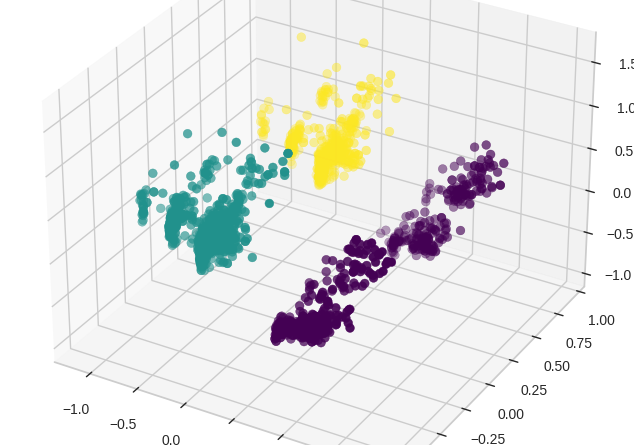

Since this is unsupervised clustering we do not have a labeled function to estimate our model. The purpose of this part of the paper is to examine the patterns in the clusters formed and to determine the nature of the clustering patterns.

To do this, let us examine the data in light of the clusters using exploratory data analysis and draw conclusions.

First, let us look at the group distribution of clustering.

<ipython-input-85-ae2c0dd38474>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data["Clusters"], palette= pal)
<ipython-input-85-ae2c0dd38474>:3: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  pl = sns.countplot(x=data["Clusters"], palette= pal)


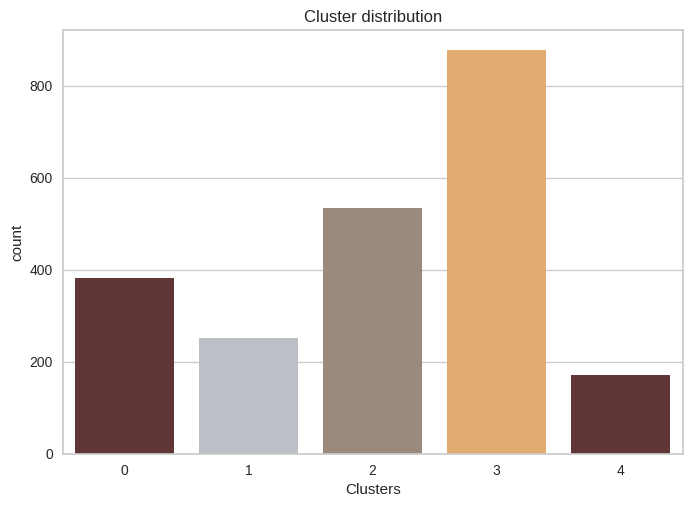

In [ ]:
#Build cluster count graph
pal = ["#682F2F", "#B9C0C9", "#9F8A78", "#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Cluster distribution")
plt.show()

The clusters, as we can see, are fairly evenly distributed.

<ipython-input-89-13ab35aee72a>:2: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)


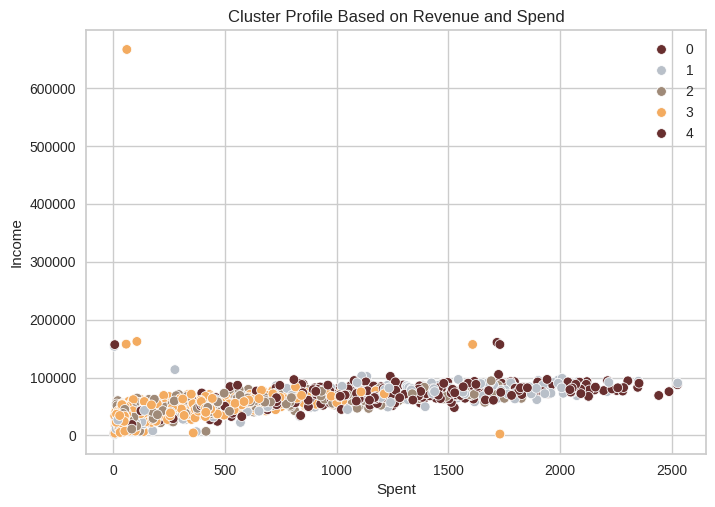

In [ ]:
data['Revenue']=revenue
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster Profile Based on Revenue and Spend")
plt.legend()
plt.show()

The graph of the ratio of income and expenses, shows the structure of clusters

group 0: high expenses and average income

group 1: high expenses and high income

group 2: low expenses and low income

group 3: high expenses and low income

Next, I will look at the detailed distribution of clusters according to the different products in the data. Namely: wines, fruits, meat, fish, sweets and gold.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 5.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 39.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 62.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-90-b75605b4d46c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pls=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
<ipython-input-90-b75605b4d46c>:3: UserWarning: 
T

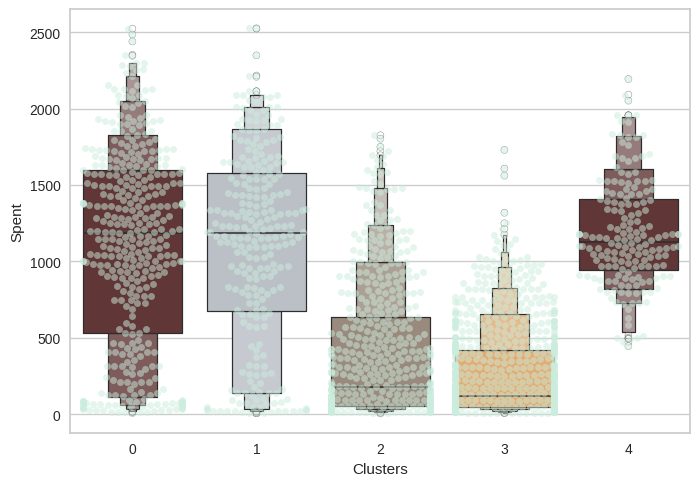

In [ ]:
plt.figure()
pls=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pls=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

From the above graph, we can clearly see that cluster 1 is our highest volume of customers, followed by cluster 0. We can examine what each cluster spends on for targeted marketing strategies.

Now let's take a look at how our companies have fared in the past

<ipython-input-94-0b311f9b6189>:5: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  pls = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)


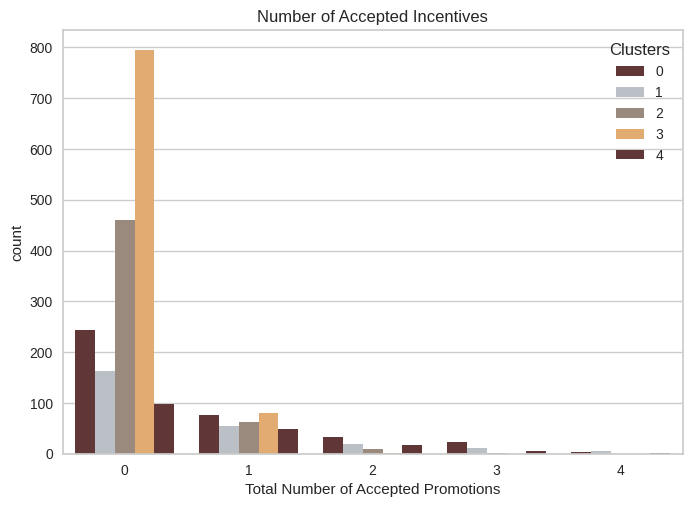

In [ ]:
#Create a function to get the sum of accepted promotions
data["Total_Promos"] = data["AcceptedCmp3"]+ data["AcceptedCmp2"]+ data["AcceptedCmp1"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Graph to count the total number of accepted campaigns
plt.figure()
pls = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pls.set_title("Number of Accepted Incentives")
pls.set_xlabel("Total Number of Accepted Promotions")
plt.show()

So far there has been no overwhelming response to these campaigns, very few participants overall. Moreover, no one is participating in all 5 of them. Perhaps more targeted and well-planned campaigns are needed to increase sales.

<ipython-input-96-99271722a8c8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
<ipython-input-96-99271722a8c8>:3: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)


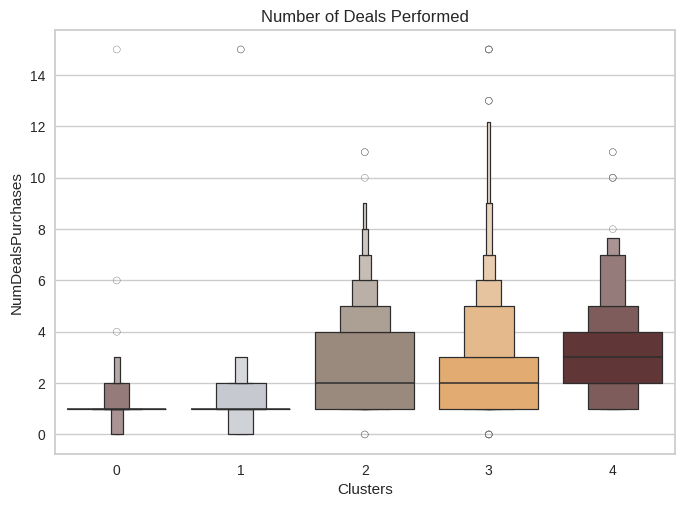

In [ ]:
#Graph of the number of conducted deals
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Performed")
plt.show()

Unlike the campaigns, the proposed deals have been successful. They have the best result with cluster 0 and cluster 3, however, our successful customers from cluster 1 are not very interested in deals, it seems that, overwhelmingly, nothing appeals.

Now that we have formed the clusters and studied their buying habits, we can look at the customers who are in these clusters. To do this, let's profile the clusters formed and come to a conclusion about who is our top customer and who needs more attention from the retail store marketing team. To solve this I will depict the characteristics that indicate the personal qualities of the customer, in view of the cluster they are in. Based on the results, conclusions can be drawn.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(x=self.x, y=self.y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1889: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


<Figure size 800x550 with 0 Axes>

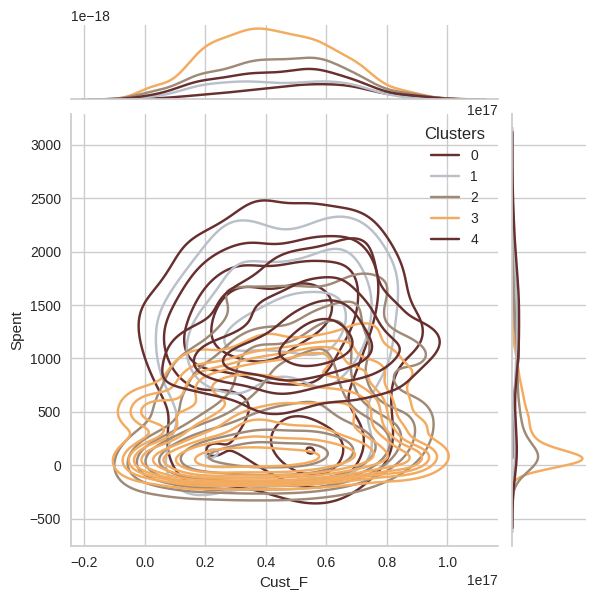

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(x=self.x, y=self.y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1889: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


<Figure size 800x550 with 0 Axes>

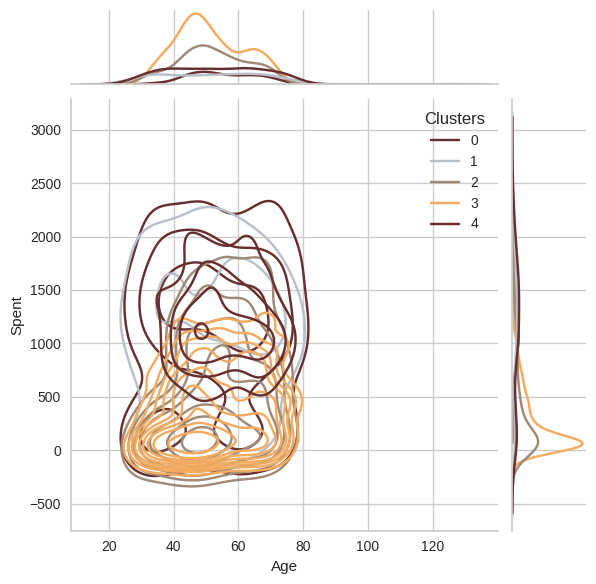

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(x=self.x, y=self.y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1889: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


<Figure size 800x550 with 0 Axes>

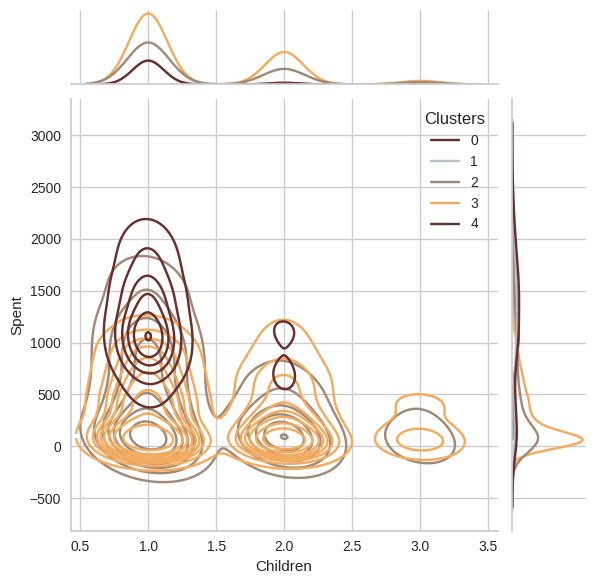

In [ ]:
Person = [ "Cust_F", "Age", "Children"]

for i in Person:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()